## Bic Vu's Capstone Project
#### ML Guild - Apprentice Cohort 11
#### Notebook 1
2023-04-13

In [2]:
import pandas as pd
import pandas_profiling as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option("display.precision", 12) # Expand number char shown to 12 instead of scientific notation

from datetime import date
today = date.today()

/var/folders/2x/fv33h81566l4630885xd8kn40000gp/T/ipykernel_72899/2930631340.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pf


In [46]:
# Create calculate_feature_statistics for quick feature overview
from pandas.api.types import is_numeric_dtype

def calculate_feature_statistics(data_frame):
    results = pd.DataFrame()
    for column in data_frame.columns:
        column_data = data_frame[column]
        if not is_numeric_dtype(column_data): continue
        num_zeros = (column_data == 0).sum()
        prop_zeros = num_zeros / len(column_data)
        num_positives = (column_data > 0).sum()
        prop_positives = num_positives / len(column_data)
        num_negatives = (column_data < 0).sum()
        prop_negatives = num_negatives / len(column_data)
        num_missing = column_data.isnull().sum()
        prop_missing = num_missing / len(column_data)
        #most_frequent_value = column_data.mode()[0]
        nunique_value = column_data.nunique()
        prop_nunique = nunique_value / len(column_data)
        min_value = column_data.min()
        max_value = column_data.max()
        median_value = column_data.median()
        feature_stats = pd.Series([num_zeros, prop_zeros, num_positives, prop_positives,
                                   num_negatives, prop_negatives, num_missing, prop_missing,
                                   #most_frequent_value, 
                                   nunique_value, prop_nunique, min_value, max_value, median_value],
                                  index=['num_zeros', 'prop_zeros', 'num_positives', 'prop_positives',
                                         'num_negatives', 'prop_negatives', 'num_missing', 'prop_missing',
                                         #'most_frequent_value', 
                                         'nunique_value', 'prop_nunique', 'min_value', 'max_value', 'median_value'])
        results[column] = feature_stats
    return results.T

In [ ]:
# Create shortcut functions to display max rows and columns
def maxcol():
    pd.set_option('display.max_columns', None)
    return

def maxcol_reset():
    pd.reset_option('display.max_columns', None)
    return

def maxrow():
    pd.set_option('display.max_rows', None)
    return

def maxrow_reset():
    pd.reset_option('display.max_rows', None)
    return

### Import raw HMDA data

In [ ]:
# Get column names
filepath = "data/2021_lar.txt"
samp = pd.read_csv(filepath, sep="|", nrows=100)
print(samp.columns)

In [ ]:
#### Read in selected columns of data
filepath = "data/2021_lar.txt"
cols = ['census_tract', 'derived_race', 'action_taken', 'loan_amount', 'property_value', 'income', 'debt_to_income_ratio', 'tract_minority_population_percent', 'tract_to_msa_income_percentage']

hmda = pd.read_csv(filepath, sep="|", usecols=cols)

In [ ]:
print(hmda.shape)
hmda.head()

In [ ]:
hmda.dtypes

In [ ]:
# Export to save file
from datetime import date
today = date.today()

# Parquet can't convert multiple format columns?
# hmda.to_parquet("data/output/hmda_2021_sel_"+str(today), index=None)

hmda.to_csv("data/output/hmda_2021_sel_"+str(today)+".csv", index=None)

#### Filter out unused data

In [ ]:
# Check for unsual properties in object columns. This has already been done on previous runs.

# maxrow()
# hmda.action_taken.value_counts()
# hmda.census_tract.value_counts()
# hmda.property_value.value_counts()
# hmda.derived_race.value_counts()

In [ ]:
# Filter for action_taken
## 1 - Loan originated -- "Approved" KEEP
# 2 - Application approved but not accepted
## 3 - Application denied -- "Denied" KEEP
# 4 - Application withdrawn by applicant
# 5 - File closed for incompleteness
# 6 - Purchased loan
# 7 - Preapproval request denied
# 8 - Preapproval request approved but not accepted
# Select application action

hmda = hmda.loc[(hmda["action_taken"]==1) | (hmda["action_taken"]==3)]
hmda.shape

In [ ]:
# Convert action_taken code
# Keep 1 as 1 for accepted values
# Convert 3 to 0 for rejected values

print(hmda["action_taken"].value_counts())
hmda["action_taken"] = hmda["action_taken"].apply(lambda x: x % 3)
hmda["action_taken"].value_counts()

In [ ]:
# Race data: drop invalid values
print(hmda.shape)
hmda = hmda.loc[~((hmda["derived_race"]=="Race Not Available") | (hmda["derived_race"]=="Free Form Text Only"))]
# df = df.loc[~((df['team'] == 'A') | (df['assists'] > 6))]
print(hmda.shape)

In [ ]:
# Drop property_value that are "Exempt", leaving only numberic value
print(len(hmda))
hmda = hmda[hmda.property_value != "Exempt"]
print(len(hmda))

In [ ]:
hmda = hmda.dropna(how="any").reset_index(drop=True)

In [ ]:
# Export to save file

# Parquet can't convert multiple format columns?
# hmda.to_parquet("data/output/hmda_2021_sel_"+str(today), index=None)

hmda.to_csv("data/output/hmda_2021_sel_clean_"+str(today)+".csv", index=None)

### Opt 2: Import saved sample data

In [181]:
# # Skip Opt 1 and import selected data rows
# hmda = pd.read_csv("data/output/hmda_2021_sel_clean_2023-06-10.csv")
# print(hmda.shape)
# hmda.head()

/var/folders/2x/fv33h81566l4630885xd8kn40000gp/T/ipykernel_72899/538237937.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  hmda = pd.read_csv("data/output/hmda_2021_sel_clean_2023-06-10.csv")


#### Converting data types and formating geographic ids

In [182]:
hmda.dtypes

census_tract                          object
derived_race                          object
action_taken                           int64
loan_amount                            int64
property_value                       float64
income                               float64
debt_to_income_ratio                  object
tract_minority_population_percent    float64
tract_to_msa_income_percentage       float64
dtype: object

In [183]:
hmda["property_value"] = pd.to_numeric(hmda["property_value"], errors='coerce')
hmda["income"] = pd.to_numeric(hmda["income"], errors='coerce')

In [184]:
# Check how many census tracts are null. Will be using geography to combine with social capital data
nan = len(hmda[hmda["census_tract"]=="nA"])
nan

1

In [185]:
# Some census tract values have decimals
hmda = hmda[hmda["census_tract"] != "nA"]
hmda["census_tract"] = pd.to_numeric(hmda["census_tract"])

In [186]:
# Check if any floats contains decimal before converting to ints
print((hmda["census_tract"] % 1  != 0).sum())
print((hmda["property_value"] % 1  != 0).sum())
print((hmda["income"] % 1  != 0).sum())

0
0
0


In [187]:
# Convert floats to ints. Removing any straggler floats and decimals.
# May need to dropnas first
hmda = hmda.dropna(how="any").reset_index(drop=True)

hmda = hmda.astype({
    "census_tract": "int",
    "property_value": "int",
    "income": "int"
})

hmda.dtypes

census_tract                           int64
derived_race                          object
action_taken                           int64
loan_amount                            int64
property_value                         int64
income                                 int64
debt_to_income_ratio                  object
tract_minority_population_percent    float64
tract_to_msa_income_percentage       float64
dtype: object

In [188]:
# Convert cleaned numeric census tract values back to string
hmda["census_tract"] = hmda["census_tract"].astype(str)
hmda.dtypes

census_tract                          object
derived_race                          object
action_taken                           int64
loan_amount                            int64
property_value                         int64
income                                 int64
debt_to_income_ratio                  object
tract_minority_population_percent    float64
tract_to_msa_income_percentage       float64
dtype: object

In [189]:
# Create a column to count the length of census tract strings
hmda["ct_count"] = hmda["census_tract"].str.len()
hmda.tail()

,census_tract,derived_race,action_taken,loan_amount,property_value,income,debt_to_income_ratio,tract_minority_population_percent,tract_to_msa_income_percentage,ct_count
13051998,12099003509,White,1,755000,1005000,5801,<20%,4.74,215.0,11
13051999,42091205200,White,1,995000,2255000,6361,<20%,10.47,178.0,11
13052000,4013216816,White,1,905000,1575000,6711,<20%,14.79,179.0,10
13052001,6037274202,White,1,2325000,2905000,9154,<20%,15.56,273.0,10
13052002,6017031700,Asian,1,595000,1085000,240,30%-<36%,23.70,236.0,10


In [190]:
# Check how many tracts have 11 char or other lengths
hmda.ct_count.value_counts()

11    10253939
10     2798064
Name: ct_count, dtype: int64

In [191]:
# Fill census_tract with leading 0 if less than 11 characters

hmda['census_tract'] = hmda['census_tract'].apply(lambda x: x.zfill(11))
hmda.tail()

,census_tract,derived_race,action_taken,loan_amount,property_value,income,debt_to_income_ratio,tract_minority_population_percent,tract_to_msa_income_percentage,ct_count
13051998,12099003509,White,1,755000,1005000,5801,<20%,4.74,215.0,11
13051999,42091205200,White,1,995000,2255000,6361,<20%,10.47,178.0,11
13052000,04013216816,White,1,905000,1575000,6711,<20%,14.79,179.0,10
13052001,06037274202,White,1,2325000,2905000,9154,<20%,15.56,273.0,10
13052002,06017031700,Asian,1,595000,1085000,240,30%-<36%,23.70,236.0,10


In [192]:
# Drop ct_count column used for data validation
hmda = hmda.drop(["ct_count"], axis=1)

In [193]:
# Drop income of zero or negative. Drop straggler nulls.
print(hmda.shape)
hmda = hmda[hmda["income"] > 0]
hmda = hmda.dropna(how="any").reset_index(drop=True)
hmda.shape

(13052003, 9)


(12987832, 9)

In [194]:
# Final count of accepted and rejected applications
print(hmda.shape)
hmda["action_taken"].value_counts()

(12987832, 9)


1    11149046
0     1838786
Name: action_taken, dtype: int64

In [195]:
feature_stats = calculate_feature_statistics(hmda)
# feature_stats.to_csv("data/output/hmda_feature_stats_"+str(today)+".csv", index=False, header=True)
feature_stats

,num_zeros,prop_zeros,num_positives,prop_positives,num_negatives,prop_negatives,num_missing,prop_missing,nunique_value,prop_nunique,min_value,max_value,median_value
action_taken,1838786.0,0.141577593551,11149046.0,0.858422406449,0.0,0.0,0.0,0.0,2.0,0.000000153990,0.0,1.0,1.00
loan_amount,0.0,0.000000000000,12987832.0,1.000000000000,0.0,0.0,0.0,0.0,975.0,0.000075070266,5000.0,1409715000.0,235000.00
property_value,0.0,0.000000000000,12987832.0,1.000000000000,0.0,0.0,0.0,0.0,1432.0,0.000110257047,5000.0,1410005000.0,355000.00
income,0.0,0.000000000000,12987832.0,1.000000000000,0.0,0.0,0.0,0.0,6392.0,0.000492152963,1.0,381000000.0,94.00
tract_minority_population_percent,5248.0,0.000404070518,12982584.0,0.999595929482,0.0,0.0,0.0,0.0,10591.0,0.000815455574,0.0,100.0,22.49
tract_to_msa_income_percentage,13073.0,0.001006557522,12974759.0,0.998993442478,0.0,0.0,0.0,0.0,371.0,0.000028565199,0.0,507.0,111.00


#### Convert tract_to_msa_income_percentage to categorical data

In [196]:
# How the data source org CFPB uses tract to msa income to determine income level for lending
# https://www.consumerfinance.gov/data-research/consumer-credit-trends/mortgages/lending-neighborhood-income-level/

bins = [0,50, 80, 120, max(hmda["tract_to_msa_income_percentage"])]
bin_labels = ["low", "moderate", "middle", "upper"]

In [197]:
hmda["income_level"] = pd.cut(hmda["tract_to_msa_income_percentage"], bins, labels=bin_labels)
hmda["income_level"] = hmda["income_level"].astype(str)
hmda.head()

,census_tract,derived_race,action_taken,loan_amount,property_value,income,debt_to_income_ratio,tract_minority_population_percent,tract_to_msa_income_percentage,income_level
0,06075030900,Joint,1,975000,1675000,123,20%-<30%,54.88,146.0,upper
1,06059052422,White,1,1125000,1925000,179,50%-60%,40.81,159.0,upper
2,06111005600,White,1,675000,1055000,114,45,46.59,110.0,middle
3,06061023800,White,1,335000,495000,68,38,9.39,101.0,middle
4,06085503330,Asian,1,1285000,2175000,115,50%-60%,89.83,174.0,upper


<function matplotlib.pyplot.show(close=None, block=None)>

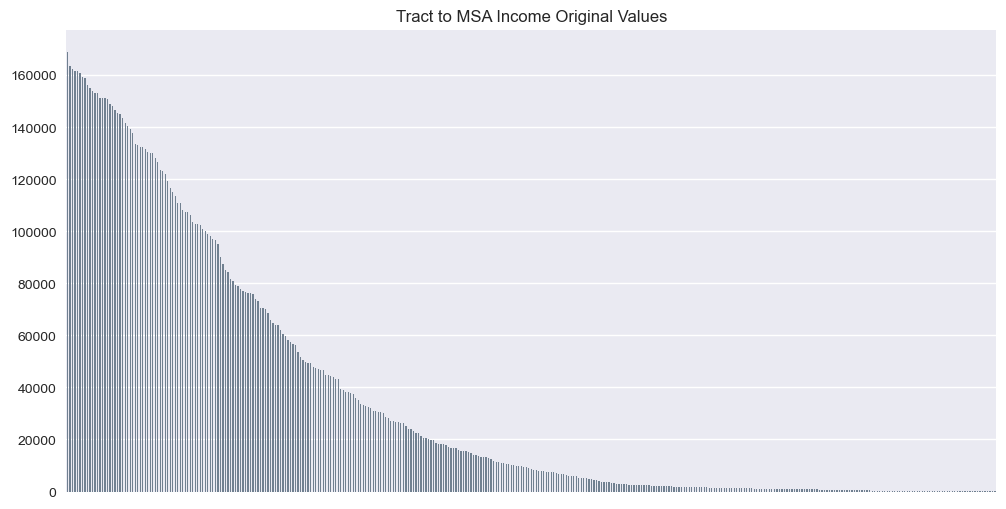

In [198]:
import matplotlib.pyplot as plt

# Plot original values
plt.style.use('seaborn-v0_8-colorblind')
# plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=[12, 6])
plt.title('Tract to MSA Income Original Values')

ax = hmda["tract_to_msa_income_percentage"].value_counts().plot(kind='bar', color = "slategray", legend=None)

# Hide X axis with too many values
ax.get_xaxis().set_visible(False)
plt.show
# plt.savefig("charts/msa_original.svg")

<function matplotlib.pyplot.show(close=None, block=None)>

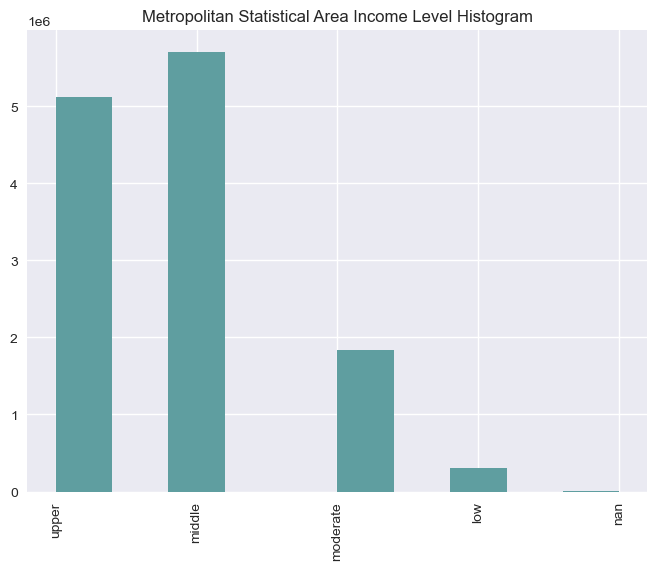

In [199]:

plt.style.use('seaborn-v0_8')
# plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=[8, 6])
plt.xticks(rotation='vertical')

plt.title('Metropolitan Statistical Area Income Level Histogram')
plt.hist(hmda["income_level"], color = "cadetblue")

plt.show
# plt.savefig("charts/msa_categorical_histogram.svg")

### ETL Debt to Income Ratio
The DTI metric has a lot of categories with few values
<p><a href = https://www.chase.com/personal/credit-cards/education/basics/what-is-debt-to-income-ratio-and-why-it-is-important#:~:text=Debt%2Dto%2Dincome%20ratio%20of,loan%20or%20line%20of%20credit.>Debt to Income categories</a>

In [200]:
hmda["debt_to_income_ratio"].value_counts()

20%-<30%    2836930
30%-<36%    2279581
<20%        1216401
50%-60%      658182
44           479918
42           473751
41           447309
>60%         446551
40           440973
39           438615
43           436717
38           424486
37           416666
36           408344
49           355362
45           339004
46           299193
48           296706
47           292467
Exempt          674
47.0              1
41.0              1
Name: debt_to_income_ratio, dtype: int64

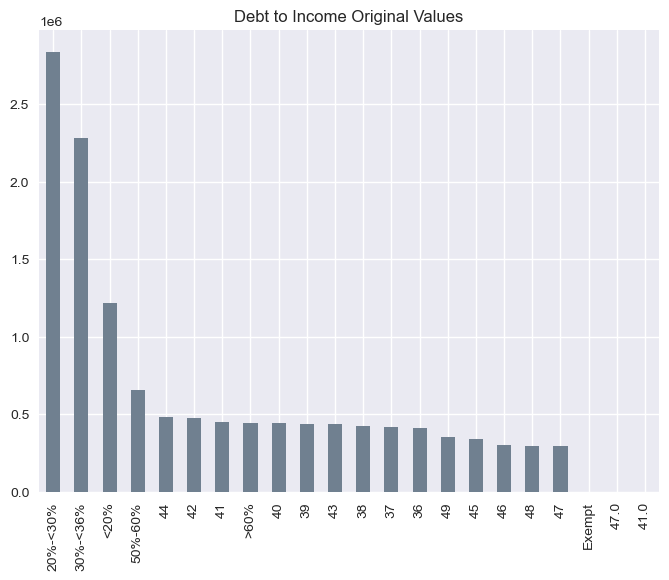

In [202]:
# Plot original values
plt.style.use('seaborn-v0_8-colorblind')
# plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=[8, 6])
plt.xticks(rotation='vertical')
plt.title('Debt to Income Original Values')

hmda["debt_to_income_ratio"].value_counts().plot(kind='bar', color = "slategray", legend=None)

plt.show
# plt.savefig("charts/dti_original.svg")

In [203]:
# Map new categories to maximun percent in category
# mapping ={
#     "<20%": "<20%",
#     "20%-<30%": "20%-<30%",
#     "30%-<36%": "30%-<36%",
#     "36": "36%-<42%",
#     "37": "36%-<42%",
#     "38": "36%-<42%",
#     "39": "36%-<42%",
#     "40": "36%-<42%",
#     "41": "36%-<42%",
#     "42": "42%-<50%",
#     "43": "42%-<50%",
#     "44": "42%-<50%",
#     "45": "42%-<50%",
#     "46": "42%-<50%",
#     "47": "42%-<50%",
#     "48": "42%-<50%",
#     "49": "42%-<50%",
#     "50%-60%": "50%-60%",
#     ">60%": ">60%"}

mapping ={
    "<20%": "20",
    "20%-<30%": "30",
    "30%-<36%": "36",
    "36": "42",
    "37": "42",
    "38": "42",
    "39": "42",
    "40": "42",
    "41": "42",
    "42": "50",
    "43": "50",
    "44": "50",
    "45": "50",
    "46": "50",
    "47": "50",
    "48": "50",
    "49": "50",
    "50%-60%": "60",
    ">60%": "100"}

hmda["dti_level"] = hmda["debt_to_income_ratio"].map(mapping)
hmda["dti_level"] = hmda["dti_level"].astype(str)
hmda["dti_level"].value_counts()

50     2973118
30     2836930
42     2576393
36     2279581
20     1216401
60      658182
100     446551
nan        676
Name: dti_level, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

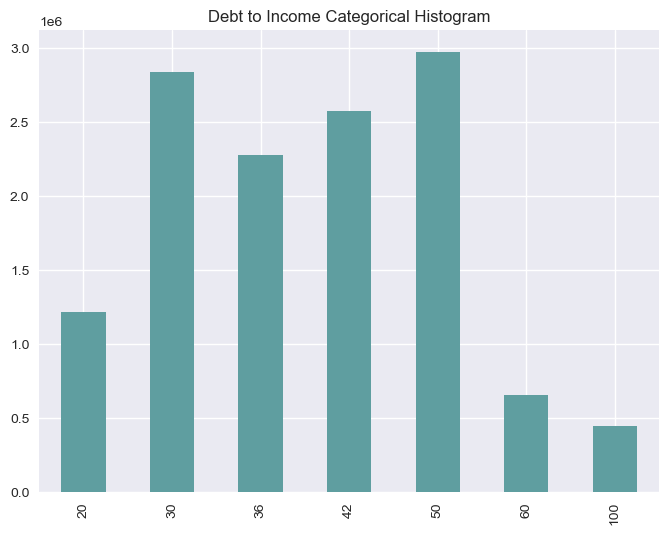

In [204]:
plt.style.use('seaborn-v0_8-colorblind')
# plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=[8, 6])

plt.xticks(rotation='vertical')
plt.title('Debt to Income Categorical Histogram')

labels = ["20%", "20%-<30%", "30%-<36%", "36%-<42%", "42%-<50%", "50%-60%", ">60%"]
sort = ["20", "30", "36", "42", "50", "60", "100"]

hmda["dti_level"].value_counts().loc[sort].plot(kind='bar', color = "cadetblue", legend=None)

plt.show
# plt.savefig("charts/dti_histogram.svg")

In [157]:
# drop original columns used to generate categorical data
hmda = hmda.drop(["debt_to_income_ratio", "tract_to_msa_income_percentage"], axis=1)

In [158]:
hmda.dropna(how="any").reset_index(drop=True)
print(hmda.shape)

(12987832, 10)


In [159]:
# Final count of accepted and rejected applications
hmda["action_taken"].value_counts()

1    11149046
0     1838786
Name: action_taken, dtype: int64

In [165]:
feature_stats = calculate_feature_statistics(hmda)
# feature_stats.to_csv("data/output/hmda_feature_stats_"+str(today)+".csv", index=False, header=True)
feature_stats

,num_zeros,prop_zeros,num_positives,prop_positives,num_negatives,prop_negatives,num_missing,prop_missing,nunique_value,prop_nunique,min_value,max_value,median_value
action_taken,1838786.0,0.141577593551,11149046.0,0.858422406449,0.0,0.0,0.0,0.0,2.0,0.000000153990,0.0,1.0,1.00
loan_amount,0.0,0.000000000000,12987832.0,1.000000000000,0.0,0.0,0.0,0.0,975.0,0.000075070266,5000.0,1409715000.0,235000.00
property_value,0.0,0.000000000000,12987832.0,1.000000000000,0.0,0.0,0.0,0.0,1432.0,0.000110257047,5000.0,1410005000.0,355000.00
income,0.0,0.000000000000,12987832.0,1.000000000000,0.0,0.0,0.0,0.0,6392.0,0.000492152963,1.0,381000000.0,94.00
tract_minority_population_percent,5248.0,0.000404070518,12982584.0,0.999595929482,0.0,0.0,0.0,0.0,10591.0,0.000815455574,0.0,100.0,22.49


#### Export data

In [161]:
# hmda.to_csv("data/output/hmda_2021_ready-for-feature_"+str(today)+".csv", index=False, header=True)

In [162]:
# hmda.to_parquet("data/output/hmda_2021_ready-for-feature_"+str(today), index=False)

### Opt A: Group data by census tract ignore race

In [ ]:
# hmda= pd.read_parquet("data/output/hmda_2021_ready-for-feature_2023-06-10")

In [ ]:
hmda.columns

In [ ]:
hmda.dtypes

In [166]:
hmda.tail()

,census_tract,derived_race,action_taken,loan_amount,property_value,income,tract_minority_population_percent,income_level,dti_level
12987827,12099003509,White,1,755000,1005000,5801,4.74,upper,20
12987828,42091205200,White,1,995000,2255000,6361,10.47,upper,20
12987829,04013216816,White,1,905000,1575000,6711,14.79,upper,20
12987830,06037274202,White,1,2325000,2905000,9154,15.56,upper,20
12987831,06017031700,Asian,1,595000,1085000,240,23.70,upper,36


In [167]:
# need to convert these categories to strings to get mode
hmda[["census_tract", "derived_race","income_level","dti_level"]] = hmda[["census_tract", "derived_race","income_level","dti_level"]].astype(str)

In [168]:
# Group by census tract
# Keep first value if multiple modes
mode = lambda x: pd.Series.mode(x)[0]

ct_group = hmda.groupby('census_tract', as_index=False).agg({
    'action_taken': pd.Series.mean,
    "loan_amount": pd.Series.mean,
    "property_value": pd.Series.mean,
    "income": pd.Series.mean,
    'tract_minority_population_percent': pd.Series.mean,
    'income_level': mode,
    'dti_level': mode,
    'derived_race': mode,
})

print(ct_group.shape)
ct_group.tail()

(72681, 9)


,census_tract,action_taken,loan_amount,property_value,income,tract_minority_population_percent,income_level,dti_level,derived_race
72676,78010971300,1.0,165000.0,225000.0,62.0,0.0,middle,36,Black or African American
72677,78010971500,1.0,175000.0,215000.0,123.0,0.0,middle,30,Black or African American
72678,78020950200,0.0,1655000.0,2505000.0,1425.0,0.0,middle,20,White
72679,78030960100,1.0,175000.0,215000.0,173.0,0.0,middle,30,White
72680,78030960400,0.5,365000.0,745000.0,94.5,0.0,upper,100,Black or African American


In [169]:
ct_group = ct_group.rename(columns={'action_taken':'approval'})

In [170]:
print(ct_group.shape)
ct_group["approval"].value_counts()

(72681, 9)


1.000000000000    683
0.800000000000    672
0.833333333333    634
0.750000000000    584
0.857142857143    562
                 ... 
0.764957264957      1
0.844978165939      1
0.850485436893      1
0.717073170732      1
0.788530465950      1
Name: approval, Length: 11948, dtype: int64

#### Export

In [171]:
ct_group[["census_tract", "derived_race", "income_level", "dti_level"]]= ct_group[["census_tract", "derived_race", "income_level", "dti_level"]].astype(str)

In [172]:
ct_group.to_csv("data/output/hmda_2021_ct_group_"+str(today)+".csv", index=False, header=True)
ct_group.to_parquet("data/output/hmda_2021_ct_group_"+str(today), index=False)

### Opt B: Group by race

In [175]:
race_counts = hmda["derived_race"].value_counts()
race_counts.to_csv("data/output/hmda_2021_race_counts_"+str(today)+".csv", index=False, header=False)
race_counts

White                                        10464415
Asian                                         1069451
Black or African American                      994630
Joint                                          321026
American Indian or Alaska Native                77313
Native Hawaiian or Other Pacific Islander       33970
2 or more minority races                        27027
Name: derived_race, dtype: int64

In [176]:
# Select race category and group by average action (percent of approval)

mode = lambda x: pd.Series.mode(x)[0]

black_group = hmda[hmda["derived_race"]=="Black or African American"].groupby('census_tract', as_index=False).agg({
    'action_taken': pd.Series.mean,
    "loan_amount": pd.Series.mean,
    "property_value": pd.Series.mean,
    "income": pd.Series.mean,
    'tract_minority_population_percent': pd.Series.mean,
    'income_level': mode,
    'dti_level': mode
})
print(black_group.shape)
black_group.tail(60)

(58305, 8)


,census_tract,action_taken,loan_amount,property_value,income,tract_minority_population_percent,income_level,dti_level
58245,72137120400,0.000000000000,115000.000000000000,135000.000000000000,49.000000000000,99.65,upper,20
58246,72137120700,1.000000000000,140000.000000000000,135000.000000000000,72.500000000000,99.61,middle,50
58247,72137120900,0.000000000000,185000.000000000000,175000.000000000000,93.000000000000,98.83,upper,30
58248,72137121001,1.000000000000,135000.000000000000,145000.000000000000,48.000000000000,99.24,upper,42
58249,72137121002,1.000000000000,65000.000000000000,85000.000000000000,25.000000000000,99.80,upper,42
58250,72137121100,0.000000000000,75000.000000000000,75000.000000000000,23.000000000000,100.00,middle,50
58251,72137121400,0.800000000000,107000.000000000000,121000.000000000000,32.800000000000,100.00,upper,60
58252,72137121701,1.000000000000,75000.000000000000,115000.000000000000,20.000000000000,100.00,upper,50
58253,72137121702,0.000000000000,95000.000000000000,85000.000000000000,24.000000000000,100.00,moderate,30
58254,72137121801,0.000000000000,85000.000000000000,75000.000000000000,18.000000000000,100.00,moderate,36


In [177]:
black_group = black_group.rename(columns={'action_taken':'approval_black'})

#### Export

In [178]:
black_group[["census_tract", "income_level", "dti_level"]]= black_group[["census_tract", "income_level", "dti_level"]].astype(str)

In [179]:
black_group.to_csv("data/output/hmda_2021_black_group"+str(today)+".csv", index=False, header=True)
black_group.to_parquet("data/output/hmda_2021_black_group"+str(today), index=False)

#### Next step: Run the Capstone_BV_ETL_SC_20230413